In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import layers
import keras

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
import os
from keras.losses import categorical_crossentropy

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)
name_file = "kdef_best"


Using TensorFlow backend.


In [2]:
data_path = 'Datasets/KDEF/Dataset_aug-4/'
data_dir_list = os.listdir(data_path)

img_rows=256
img_cols=256
num_channel=1

num_epoch=10

img_data_list=[]
img_list_temp = 0

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    
    img_list_temp = len(img_list) + img_list_temp
    
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48), interpolation=cv2.INTER_LINEAR)
        input_img_resize = input_img_resize.reshape(48, 48, 1)
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255

Loaded the images of dataset-Angry

Loaded the images of dataset-Disgust

Loaded the images of dataset-Fear

Loaded the images of dataset-Happy

Loaded the images of dataset-Neutral

Loaded the images of dataset-Sad

Loaded the images of dataset-Surprise



In [3]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:1399]=0 #700
labels[1400:2799]=1 #700
labels[2800:4199]=2 #700
labels[4200:5599]=3 #700
labels[5600:6999]=4 #700
labels[7000:8399]=5 #700
labels[8400:9799]=6 #700

names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

def getLabel(id):
    return ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'][id]

Y = np_utils.to_categorical(labels, num_classes)
x,y = shuffle(img_data,Y, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [4]:
from keras.models import load_model
from keras_layer_normalization import LayerNormalization
import tensorflow as tf

model_path = "models/KDEF/" + name_file + ".hdf5"
model = load_model(model_path, compile=False, custom_objects = {'LayerNormalization':LayerNormalization, 'tf':tf})
model.summary()

model.compile(loss=categorical_crossentropy,
             optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])


score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 48, 48, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 48, 48, 64)   256         activation_1[0][0]               
____________________________________________________________________________________________

Normalized confusion matrix


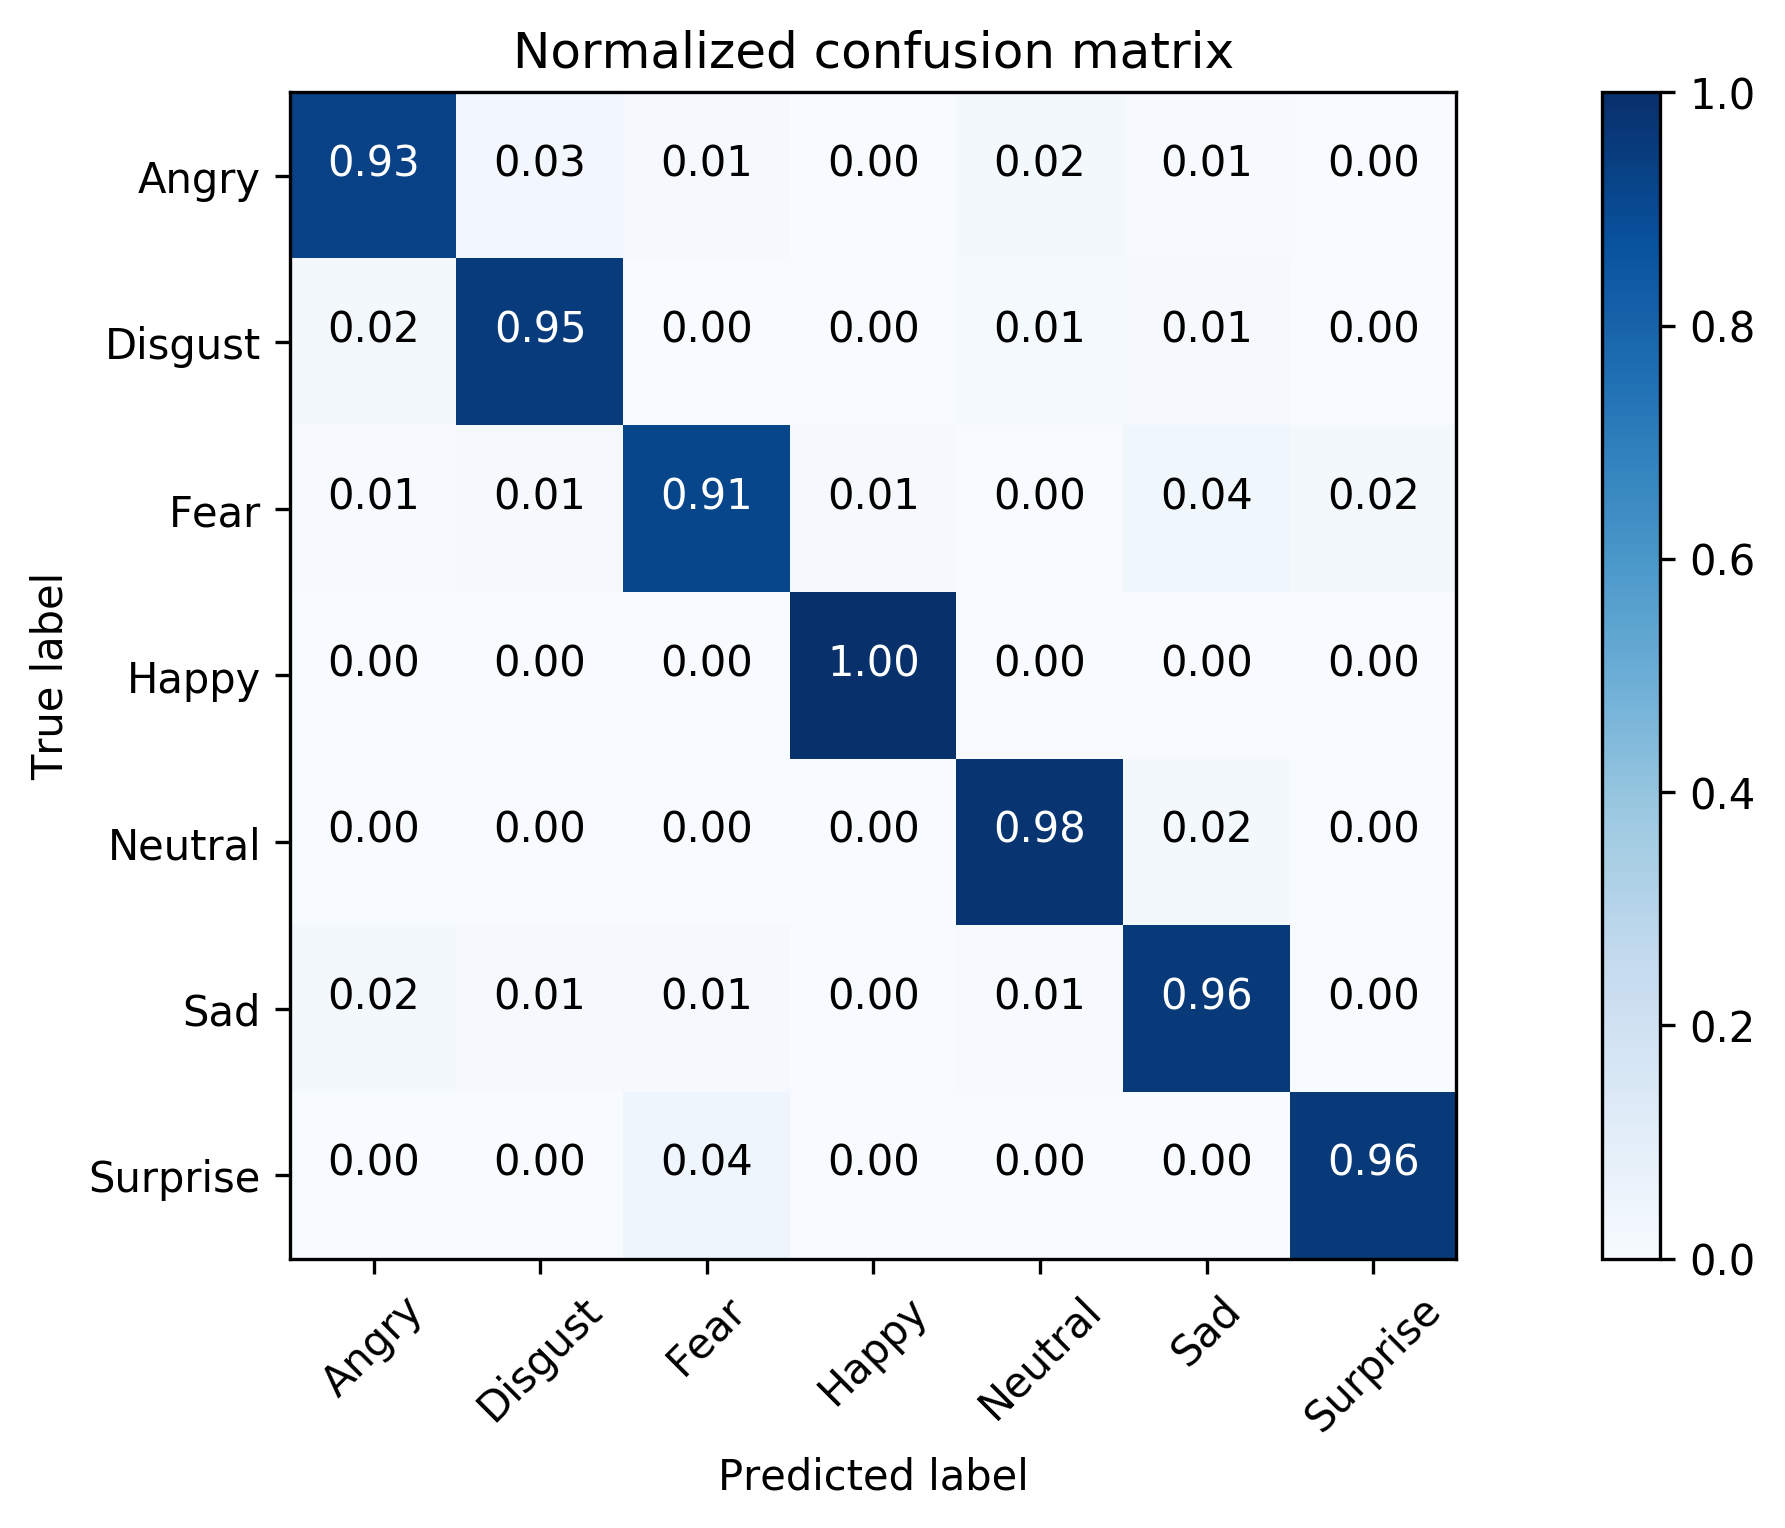

In [5]:
from sklearn.metrics import confusion_matrix
import itertools
rcParams['figure.figsize'] = 10, 5
#results = model.predict_classes(X_test)
y_prob = model.predict(X_test) 
results = y_prob.argmax(axis=-1)

cm = confusion_matrix(np.where(y_test == 1)[1], results)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
title='Confusion matrix'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

fig = plt.figure(dpi=300)
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
fig.savefig('KDEF.png',dpi=300)